# I. Introduction

# II. Methodology

    In order to make this estimate concerning the number of pregnant women, we used data from our system, HIV Haiti, such as the PMTCT mastersheet and EID data from January 2018 to April 2021, but also data from MESI in order to have some idea of the number of women enrolled in a PMTCT program at the national level, for the same period.
    
    After downloading the different datasets, data are grouped by month because the estimation will be done on a monthly basis. The different variables of interest are drawn from each dataset, such as the number of women with a probable delivery date or the available delivery date as well as the PCR tests recorded on the PMTCT mastersheet, the number of children having benefited from a PCR test born from January 2018 on the EID dataset and finally the number of women seen in CPN1 registered on MESI. A first descriptive analysis is made via a few graphs which provide an overview and give us some insights.
    
    Next, we proceed with the modeling using a simple linear regression model to specify the relationship between the number of PCR tests and the number of pregnant women duly registered in the mastersheet, then finally, we will use the parameters obtained from the model to make the estimation of the number of pregnant women regarding the number of children who received a PCR test from the EID dataset. Linear regression is a linear approach to modelling the relationship between a scalar response and one or more explanatory variables (also known as dependent and independent variables), that is to say trying to explain a quantitative variable (y) using other variables (X) via a function denoted "f" allowing to write:
    
                                                     y = f(X)
                                                     
    In the case, the expression of this function is:
                    
                                                     y = a*X + b
    a and b are parameters to be estimated.

# III. Data wrangling

    Data wrangling, also called data cleaning, is an important part when performing data analysis. This is the process of transforming and mapping data from one raw data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes, for better decisions making. Within the framework of this work, the preparation of the data will consist in the selection of the variables of interest, the creation of new date columns and the grouping of the data by period.

### - Importing the required packages

In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from dateutil.parser import parse
from pandas import NaT
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import seaborn as sns
import plotly.express as px
import numpy as np
import locale
locale.setlocale(locale.LC_ALL, 'fr_FR')

'fr_FR'

### - Importing and reading the datasets

    In this part, we import the different datasets and get some preview of the data.

In [2]:
#Importing the data
eid_file = pd.read_excel('EID_all_data_18-21.xlsx', parse_dates = True)
mastersheet_file = pd.read_excel('Mastersheet_2018.xlsx', parse_dates = True)
mesi_file = pd.read_excel('Mesi_report_18-21.xlsx', usecols = ['Row Labels', 'Grand Total'], skipfooter = 1,
                          sheet_name = 'MESI')

In [3]:
#Reading the EID dataset
eid_file.head(1)

Patient_code         Code_mere Liaison_mere Site_or_lab_code  \
0  GON/HLPG/50501GN  GON/HLPG/ST00489          yes         GON/HLPG   

                                    hospital Office Network date_of_birth  \
0  HÃ´pital Secours- Providence des Gonaives    GON     UGP    2017-10-05   

  gender arv_start  ... days_in_lab         Nbres_jours_Labo  \
0    NaN       NaN  ...          19  Ndays_Labo_more_than_15   

  days_between_caris_lab                 Nbres_jours_Caris pos_dead_abandon  \
0                      1  Ndays_Caris_equal_or_less_than_5              NaN   

  death_date abandoned_date      pcr_result_date  Quarter  Year  
0        NaN            NaN  2017-11-14 00:00:00       Q1  2018  

[1 rows x 33 columns]

In [4]:
#Reading the PMTCT mastersheet
mastersheet_file.head(1)

id_patient mother_patient_code          created_at      Site first_name  \
0         243    PAP/HAHD/ST00362 2011-12-14 06:47:45  PAP/HAHD        NaN   

  last_name                               Hospital network Muso_program  \
0       NaN  HÃ´pital Adventiste d'Hait de Diquini  autres          Yes   

  gardening_program  ...         health_id  \
0               Yes  ...  PAP/HAHD/ST00362   

  is_patient_present_at_time_of_visit consent_of_visit_comments  \
0                                 1.0                       NaN   

         type_of_visit date_of_visit Date_of_Delivery_Commcare  \
0  reason_mothers_club    2018-05-16                       NaT   

  Infant_Prophylaxis_Commcare  delivery_date_merge  \
0                     Inconnu  2017-06-20 00:00:00   

  delivery_probality_date_merge  DPA_calculated  
0           2017-06-20 00:00:00             NaN  

[1 rows x 71 columns]

In [5]:
#Reading the MESI dataset. We only imported these two columns since they are the important ones.
mesi_file.head()

Row Labels  Grand Total
0   OCTOBRE 2017           76
1  NOVEMBRE 2017           76
2  DECEMBRE 2017           43
3   JANVIER 2018           81
4   FEVRIER 2018          104

### - Preparing the data from MESI, descriptive statistics and visualization

In [6]:
def capital(x):
    return x.capitalize()

mesi_file['Row Labels'] = mesi_file['Row Labels'].map(capital)

year = [2017, 2018, 2019, 2020, 2021]
for i in year:
    mesi_file['Row Labels'].replace({f'Decembre {i}' : f'Décembre {i}',
                                f'Fevrier {i}' : f'Février {i}',
                                f'Aout {i}' : f'Août {i}'}, inplace = True)
    
mesi_file.rename(columns = {'Row Labels' : 'month',
             'Grand Total' : 'total_ptme_recorded_mesi'}, inplace = True)
ptme_mesi = mesi_file

print('\nA preview of the number of women registered on MESI by month: ')
ptme_mesi.head()
print('\nDescriptive statistics: ')
ptme_mesi.describe()


A preview of the number of women registered on MESI by month: 


month  total_ptme_recorded_mesi
0   Octobre 2017                        76
1  Novembre 2017                        76
2  Décembre 2017                        43
3   Janvier 2018                        81
4   Février 2018                       104


Descriptive statistics: 


total_ptme_recorded_mesi
count                 43.000000
mean                  93.093023
std                   24.246565
min                   43.000000
25%                   77.000000
50%                   88.000000
75%                  107.000000
max                  171.000000

In [7]:
#Plotting the number of women registered on MESI for the period
px.bar(ptme_mesi, x = 'month', y = 'total_ptme_recorded_mesi', 
       title = 'Recorded women in PMTCT program on MESI by month _ January 2018 - April 2021' ,
       labels={'month' : 'Month', 'total_ptme_registered_mesi': 'Number of PTME'})

    MESI data were processed and standardized to derive the necessary information and allow comparison with data from HIV Haiti. Data from October 2017 has been drawn, but only data from 2018 will be used further.

### - Preparing the PMTCT mastersheet data, descriptive statistics and visualization

In [8]:
def get_month(date):
    if type(date) == type(NaT):
        return '---'
    else:
        return f"{date.strftime('%B').capitalize()} {str(date.year)}"

###########################################################################################################################

start_date = parse('2018-01-01')

mastersheet_file['delivery_probality_date_merge'] = pd.to_datetime(mastersheet_file['delivery_probality_date_merge'], 
                                                                   errors = 'coerce')
mothers_hiv = mastersheet_file[mastersheet_file['delivery_probality_date_merge'] >= 
                               start_date][['mother_patient_code', 'delivery_probality_date_merge']]
mothers_hiv = mothers_hiv.reset_index(drop = True)

###########################################################################################################################

#Set up the delivery dataset 

mothers_hiv['delivery_probability_month'] = mothers_hiv['delivery_probality_date_merge'].map(get_month)

#Group by delivery_date_month
delivery_hiv = mothers_hiv.groupby('delivery_probability_month').count()[['mother_patient_code']]
delivery_hiv.reset_index(inplace = True)
delivery_hiv.rename(columns = {'delivery_probability_month': 'month',
                              'mother_patient_code' : 'total_birth_ptme'}, inplace = True)
delivery_hiv = ptme_mesi.merge(delivery_hiv, on = 'month', how = 'left')
delivery_hiv.drop('total_ptme_recorded_mesi', axis = 1, inplace = True)
delivery_hiv.drop(labels = [0,1,2], axis = 0, inplace = True)

print("\nA preview of the number of pregnant women or women having given birth on the Mastersheet by month: ") 
delivery_hiv.head()
delivery_hiv.describe()
###########################################################################################################################

#Set up the pcr dataset
pcr = mastersheet_file[mastersheet_file['date_blood_taken'] >= 
                       start_date][['mother_patient_code', 'date_blood_taken']]
pcr['pcr_month'] = pcr['date_blood_taken'].map(get_month)
pcr_ptme = pcr.groupby('pcr_month').count()[['mother_patient_code']]
pcr_ptme.reset_index(inplace = True)
pcr_ptme.rename(columns = {'pcr_month': 'month',
                          'mother_patient_code': 'pcr_ptme'}, inplace = True)
pcr_ptme = ptme_mesi.merge(pcr_ptme, on = 'month', how = 'left')
pcr_ptme.drop('total_ptme_recorded_mesi', axis = 1, inplace = True)
pcr_ptme.drop(labels = [0,1,2], axis = 0, inplace = True)
print("\n\nA preview of the number of PCR test performed by month recorded on the PMTCT Mastersheet :")
pcr_ptme.head()
pcr_ptme.describe()


A preview of the number of pregnant women or women having given birth on the Mastersheet by month: 


month  total_birth_ptme
3  Janvier 2018             179.0
4  Février 2018             193.0
5     Mars 2018             180.0
6    Avril 2018             165.0
7      Mai 2018             151.0

total_birth_ptme
count         36.000000
mean          49.361111
std           74.964050
min            1.000000
25%            3.750000
50%            7.500000
75%           68.000000
max          224.000000



A preview of the number of PCR test performed by month recorded on the PMTCT Mastersheet :


month  pcr_ptme
3  Janvier 2018     135.0
4  Février 2018     125.0
5     Mars 2018     141.0
6    Avril 2018     124.0
7      Mai 2018     122.0

pcr_ptme
count   23.000000
mean    63.347826
std     59.257227
min      1.000000
25%      7.000000
50%     25.000000
75%    122.000000
max    154.000000

In [9]:
#Plotting the delivery and pcr test data
px.bar(delivery_hiv, x = 'month', y = 'total_birth_ptme', 
       title = 'Delivery date and DPA on Mastersheet PTME by month _ January 2018 - April 2021', 
       labels = {'month': 'Month'})
px.bar(pcr_ptme, x = 'month', y = 'pcr_ptme', 
       title = 'PCR test recorded on the PMTCT Mastersheet by month _ January 2018 - April 2021', 
       labels = {'month': 'Month', 'pcr_ptme':'Number of PCR test'})

    The two previous graphs give us the number of pregnant women or having given birth as well as the number of PCR tests realized recorded on the PMTCT mastersheet. We can see that around and after October-November 2018, the flow of information has completely decreased, going down to 0 for some months for the two variables in question, unlike MESI which maintains a certain consistency. An investigation is necessary to identify the cause(s) of this decline.

### - Preparing the EID data, descriptive statistics and Visualization

In [10]:
eid = eid_file[eid_file['date_of_birth'] >= '2018-01-01'][['Patient_code', 
                                                           'date_of_birth']].reset_index(drop = True)

print('\nA previous of EID raw data:')
eid.head()
print(f"According to the data available, we have {eid.shape[0]} children born after January 1st 2018 to April 30th 2021 who have benefited a PCR test.")


A previous of EID raw data:


Patient_code date_of_birth
0  PAP/SMFO/ST00483    2020-09-05
1  PEG/HNDP/ST02668    2018-02-01
2  CAP/HFSM/ST00482    2020-10-01
3  PAP/CMSP/ST00183    2018-03-18
4  PAP/CSCB/ST03040    2018-04-03

According to the data available, we have 11681 children born after January 1st 2018 to April 30th 2021 who have benefited a PCR test.


In [11]:
#creating new date column
eid['month'] = eid['date_of_birth'].map(get_month)

#grouping data by month
eid_by_month = eid.groupby('month').count()[['Patient_code']]
eid_by_month.reset_index(inplace = True)
eid_by_month.rename(columns = {'Patient_code' : 'total_birth'}, inplace = True)
eid = ptme_mesi.merge(eid_by_month, on = 'month', how = 'left')
eid.drop('total_ptme_recorded_mesi', axis = 1, inplace = True)
eid.drop(labels = [0,1,2], axis = 0, inplace = True)

print('\nA previous of EID data used in the analysis: ')
eid.head()
print('\nDescriptive statistics for EID: ')
eid.describe()

#Plotting the data
px.bar(eid, x = 'month', y = 'total_birth', 
       title = 'Number of children born by month who have benefited a PCR test _ January 2018 - April 2021', 
       labels = {'total_birth': 'Number of birth', 'month': 'Month'})


A previous of EID data used in the analysis: 


month  total_birth
3  Janvier 2018        306.0
4  Février 2018        282.0
5     Mars 2018        259.0
6    Avril 2018        245.0
7      Mai 2018        220.0


Descriptive statistics for EID: 


total_birth
count    40.000000
mean    292.025000
std      67.644049
min      78.000000
25%     246.500000
50%     293.500000
75%     328.750000
max     424.000000

## Merging all 4 prepared datasets

In this section, all previous generated datasets such as MESI dataset, PMTCT datasets regarding the number of 

In [12]:
all_data = ptme_mesi.merge(eid, on = 
                           'month', how = 'left').merge(delivery_hiv, on = 
                                                        'month', how = 'left').merge(pcr_ptme, on = 
                                                                                     'month', how = 'left')
all_data.drop(labels = [0,1,2], axis = 0, inplace = True)
columns = ['month', 'total_birth', 'total_ptme_recorded_mesi', 'total_birth_ptme', 'pcr_ptme']
all_data = all_data.reindex(columns = columns)
all_data['total_birth_ptme'] = all_data['total_birth_ptme'].fillna(0)
all_data['pcr_ptme'] = all_data['pcr_ptme'].fillna(0)

all_data.head(10)

month  total_birth  total_ptme_recorded_mesi  total_birth_ptme  \
3     Janvier 2018        306.0                        81             179.0   
4     Février 2018        282.0                       104             193.0   
5        Mars 2018        259.0                        88             180.0   
6       Avril 2018        245.0                       133             165.0   
7         Mai 2018        220.0                       133             151.0   
8        Juin 2018        247.0                       110             146.0   
9     Juillet 2018        244.0                        88             158.0   
10       Août 2018        289.0                        85             182.0   
11  Septembre 2018        323.0                        82             224.0   
12    Octobre 2018        387.0                       102              42.0   

    pcr_ptme  
3      135.0  
4      125.0  
5      141.0  
6      124.0  
7      122.0  
8      103.0  
9      120.0  
10     122.0  
11     154.0  
12     117.0

### Correlation coefficient between features

In [13]:
#Determining the correlation coefficient
import scipy.stats as st

print(f"Correlation coefficient: {st.pearsonr(all_data['pcr_ptme'], all_data['total_birth_ptme'])[0]}")

Correlation coefficient: 0.9402280778826825


<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Pearson correlation of features')

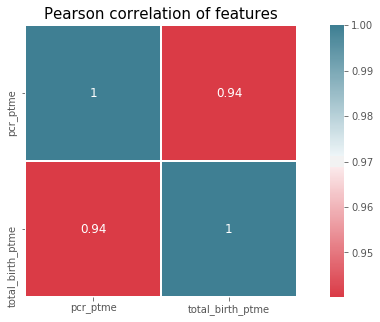

In [25]:
#Plotting the variance-covariance matrix
plt.figure(figsize = (12, 5))
plt.title('Pearson correlation of features', size = 15)
colormap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(all_data[['pcr_ptme', 'total_birth_ptme']].corr(),
           cmap = colormap,
           square = True,
           annot = True,
           linewidths = 0.1, vmax = 1.0, linecolor = 'white',
           annot_kws = {'fontsize':12}
           )

plt.show()

# Modelling

    As we said earlier, we are using a linear regression model to estimate the parameters which will allow us to find the relationship between the number of PCR test performed for the mothers children on the mastersheet and the number of pregnant women also on the mastersheet. The previous graph (Number of pcr test regarding the number of pregnant women) and the coefficient correlation calculated allow us to assume that there is indeed a linear relationship between these two variables.
    
    We'll use the statistical module "statsmodels.api" in python in order to perform this linear regression and the estimation by Ordinary Least Squares (OLS). The main information of the output will be the estimated parameters and the subsequent statistical tests required to see if the paramaters are statistically significant and if the model is correctly specified.

In [15]:
#Performing the modeling
#Simple linear regression

import statsmodels.api as sm
Y = all_data['total_birth_ptme']
X = all_data[['pcr_ptme']]
X = X.copy()
X['intercept'] = 1
result = sm.OLS(Y,X).fit()
a,b = result.params['pcr_ptme'], result.params['intercept']

In [16]:
print(f"Coefficient alpha: {round(a, 4)}.")
print(f"Intercept: {round(b, 4)}.")

Coefficient alpha: 1.2487.
Intercept: -1.0605.


### Comments

    As expected, we obtained the two estimated parameters of the model, a and b, since we have only one explanatory variable.
    Thus, our dependent variable is expressed as a function of the explanatory variable by: 
                                    
                                        y = 1.2487 * X - 1.0605.
                                        
    It's a growing relationship indicating the natural higher number of pregnant women compared to born children who received PCR tests.

### Linear regression line plot

Text(0.5, 1.0, 'Number of PCR test by number of pregnant women')

Text(0.5, 0, 'Number of PCR test')

Text(0, 0.5, '')

Text(0.5, 1.0, 'Zoom in on the dense area of the scatter plot')

Text(0.5, 0, 'Number of PCR test')

Text(0, 0.5, 'Number of pregnant women')

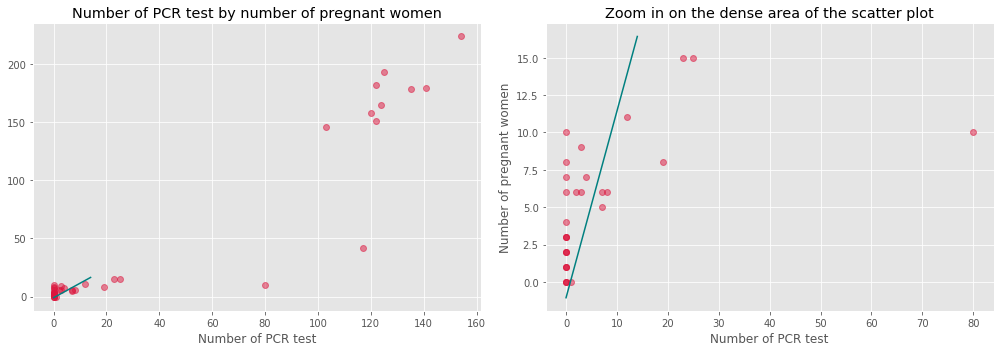

In [17]:
#Zoom in the dense zone of points
all_data_prime = all_data.drop(labels = [3,4,5,6,7,8,9,10,11,12], axis = 0)

fig = plt.figure(figsize = (14, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(all_data['pcr_ptme'], all_data['total_birth_ptme'], 'o', alpha = 0.5, color = 'crimson')
ax1.plot(np.arange(15), [a*x+b for x in np.arange(15)], color = 'teal')
ax2.plot(all_data_prime['pcr_ptme'], all_data_prime['total_birth_ptme'], 'o', alpha = 0.5, color = 'crimson')
ax2.plot(np.arange(15), [a*x+b for x in np.arange(15)], color = 'teal')

# ax1.legend()
ax1.set_title('Number of PCR test by number of pregnant women')
ax1.set_xlabel('Number of PCR test')
ax1.set_ylabel('')

# ax2.legend()
ax2.set_title('Zoom in on the dense area of the scatter plot')
ax2.set_xlabel('Number of PCR test')
ax2.set_ylabel('Number of pregnant women')

plt.tight_layout()

plt.show()

### Model summary

    The table below gives us a summary of the results, the model presented here was trained on a database containing 40 observations of two quantitative variables, and we got the following estimate: 

                                                y = 1.2487*X - 1.0605, 
                                         
    with y: "total_birth_ptme" and X: "pcr_ptme". The variable "pcr_ptme", that is to say the number of PCR tests which were realized for the mothers' children present on the system for the period from January 2018 to April 2021, explains at 88.1% the variation of the variable "total_birth_ptme" which is an estimate of the number of pregnant and giving birth women in the system for the period.

    Since we performed a simple linear regression, the Fisher statistic and the Student statistic are relatively the same and reflect whether the coefficients are significant, the Fisher test being a joint nullity test of the set of coefficients. To conclude if the estimated coefficients are statistically different from 0, the probabilities relating to these two tests can help us, the decision rule stipulating that if this probability is less than 0.05 (the threshold generally used), it implies that the coefficients are statistically not zero. Thus, in the table presented, we notice that the probability associated with the Fisher statistic is equal to 2.28e-19 (very close to 0.000), indicating to us that there is at least one estimated coefficient which is statistically significant.
    
    In the second section of the table where the statistics of the estimated coefficients are displayed (coef, std err, t, P> |t|, ...), we can notice that the probability associated with the Student test for the parameter of the independent variable (P> | t |: pcr_ptme) is relatively close to 0 (0.000), therefore less than 0.05, which reflects the statistical non-nullity of this parameter. However, this is not the case for the intercept which has a p-value greater than 0.05 (0.826).


In [18]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       total_birth_ptme   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     289.7
Date:              dim., 06 juin 2021   Prob (F-statistic):           2.28e-19
Time:                        23:08:30   Log-Likelihood:                -184.55
No. Observations:                  40   AIC:                             373.1
Df Residuals:                      38   BIC:                             376.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pcr_ptme       1.2487      0.073     17.020      0.0

# Estimation

In [19]:
all_data['PTME_ESTIMATION'] = round(all_data['total_birth']*a + b, 0)

all_data.head()

month  total_birth  total_ptme_recorded_mesi  total_birth_ptme  \
3  Janvier 2018        306.0                        81             179.0   
4  Février 2018        282.0                       104             193.0   
5     Mars 2018        259.0                        88             180.0   
6    Avril 2018        245.0                       133             165.0   
7      Mai 2018        220.0                       133             151.0   

   pcr_ptme  PTME_ESTIMATION  
3     135.0            381.0  
4     125.0            351.0  
5     141.0            322.0  
6     124.0            305.0  
7     122.0            274.0